# Programmeerproject Fysica van Galaxiën

Eerst en vooral zijn hier de nodige libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mayavi import mlab
import colorsys #conversie tussen verschillende kleursystemen
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

multiple 'pyface.toolkits' plugins found for toolkit 'qt4': pyface.ui.qt4.init, pyface.ui.qt4.init


En de te gebruiken constantes:

In [2]:
G = 4.3009*10**(-6)

De 2 intragerende kernen zijn een 2-lichamenvraagstuk die analytisch op te lossen valt. We hebben gegeven:

In [3]:
# galaxie1:
M1 = 10**11
I1= np.pi/3
Omega1 = np.pi/6
R1_0 = [0,0,0]
V1_0 = [0,0,0]
#galaxie2:
M2 = 10**11
I2= np.pi/3
Omega2 = np.pi/6
R2_0 = [-45,0, 0]
V2_0 = [71,-120, 0]

Waaruit:

In [4]:
mu = G*(M1+M2)
BaanEnergie=(V2_0[0]**2 + V2_0[1]**2 + V2_0[2]**2)/2 - mu/((R2_0[0]**2 + R2_0[1]**2 + R2_0[2]**2)**(1/2))

print(BaanEnergie)

-9394.611111111113


We hebben dus te maken met een ellips met lange as a en baanfrequentie n:

In [5]:
a = -mu/(2*BaanEnergie)
n = np.sqrt(mu/(abs(a)**3))

Nu wordt het draaimoment gegeven door $\vec{L} = \vec{r}\times\vec{p}$, nu is $h = |\frac{\vec{L}}{m}|$ en dus:

In [6]:
h = np.linalg.norm(np.cross(R2_0,V2_0))
#Hoewel er in de opgave draaimoment staat heb ik herrekend dat dit gereduceert dient te zijn

Nu is de eccentriciteit gegeven door $e=\sqrt{1 - \frac{h^2}{\mu a}}$:

In [7]:
e = np.sqrt(1 - (h**2)/(mu*a))

Voor een gegeven tijd kunnen we de Middelbare Anomalie berekenen door deze te vermenigvuldigen met de baanfrequentie n en dan de eccentrische anomalie E uit het iteratief oplossen (newton-rhapson) van de vergelijking:
$$E = M + e\sin{E}$$
De onderlinge afstand tussen beide galaxiekernen kan dan gevonden worden door $$r = a(1-\cos{E})$$

In [8]:
e_vec = 1/mu*np.cross(V2_0,np.cross(R2_0,V2_0)) - R2_0/np.linalg.norm(R2_0) #dient om te roteren van x'y' naar xy
E_init = -np.arccos((a-np.linalg.norm(R2_0))/(a*e))
M0 = E_init - e*np.sin(E_init) #dient om de startpositie weer te geven
periode_P = 2*np.pi*a*np.sqrt(a/mu)

In [9]:
def kernposities(tijd):
    #Middelbare Anomalie E
    E0 = M0 + n*tijd
    E = E0
    for k in range(0,10):
        E = E0 + e*np.sin(E) # M + e*sin(E) = E
    R2 = [0,0,0]    
    x = a*(np.cos(E) - e)
    y = a*np.sqrt(1-e**2)*np.sin(E)
    R2[0] = x*e_vec[0]/e - y*e_vec[1]/e
    R2[1] = x*e_vec[1]/e + y*e_vec[0]/e
    return R2

Hier nu een korte animatie van hoe de kernen rond elkaar bewegen:

In [10]:
%%capture
X,Y = [],[]
for tijd in range(0,300):
    r2_ = kernposities(tijd*0.02)
    X.append(r2_[0])
    Y.append(r2_[1])
    print(np.sqrt(r2_[1]**2+r2_[0]),tijd*0.02)
    
fig,ax = plt.subplots()
T = np.arange(0,300,1)
def animate(i):
    ax.clear()
    ax.scatter(0,0,color = 'r')
    ax.scatter(X[i],Y[i])
    ax.set_xlim(-200,200)
    ax.set_ylim(-200,200)
    
anim = FuncAnimation(fig, animate,frames=300, interval=10)

In [11]:
HTML(anim.to_jshtml())

De sterren zijn onderheven aan de zwaartekracht van beide galaxiën en volgen de volgende bewegingsvergelijking:

$$\ddot{\vec{r}}_* = \frac{d\vec{v}_*}{dt} = G\frac{M_1}{|\vec{r}_*-\vec{R}_1|^3}(\vec{R}_1-\vec{r}_*) + G\frac{M_2}{|\vec{r}_*-\vec{R}_2|^3}(\vec{R}_2-\vec{r}_*)$$

In het referentiestelsel die met de kern van de eerste galaxie meebeweegt geldt:
$$\vec{R}' = \vec{R}_2-\vec{R}_1$$
$$\vec{r}'_* = \vec{r}_*-\vec{R}_1$$
$$\ddot{\vec{r}}'_* = \frac{d\vec{v}'_*}{dt} = -G\frac{M_1}{|\vec{r}'_*|^3}\vec{r}'_* + G\frac{M_2}{|\vec{R}'-\vec{r}'_*|^3}(\vec{R}'-\vec{r}'_*) - G\frac{M_2}{|\vec{R}'|^3}\vec{R}'$$

Deze vergelijking kan gesplitst worden in zes gekoppelde partiële differentiaalvergelijkingen:
$$\frac{dv'_{*_i}}{dt} = -G\frac{M_1}{|\vec{r}'_*|^3}r'_{*_i} + G\frac{M_2}{|\vec{R}'-\vec{r}'_*|^3}(R'_{i}-r'_{*_i}) - G\frac{M_2}{|\vec{R}'|^3}R'_{i}$$
$$\frac{dr'_{*_i}}{dt} = v'_{*_i}$$
$$i = 1,2,3$$

In code wordt dit dus:

In [12]:
def norm(r):
    return np.linalg.norm(r)

def vergelijking_stersnelheid(R,r,i):
    return G*(-M1*r[i]/(norm(r)**3)+ M2*(R[i]-r[i])/(norm(np.subtract(R,r))**3) - M2*R[i]/(norm(R)**3))   

Dit stelsel vergelijkingen kan ogelost worden met behulp van scipy.integrate.odeint:

In [13]:
def ODEs(q, t):
    r = [q[0],q[1],q[2]]
    dv = np.zeros(3)
    for i in range(3):   
        dv[i] = vergelijking_stersnelheid(kernposities(t),r,i)
    return [q[3], q[4], q[5], *dv]
    
def update_ster(v0,r0,T,t0=0,n=80000):
    q0 = [*r0, *v0] #q = [x,y,z,vx,vy,vz]
    t = np.array([*np.linspace(t0, T, n)])
    return odeint(ODEs, q0, t)


Een 2D test voor de aarde (hierbij werd vanuit het perihelium gestart op een snelheid van $30.29 \frac{km}{s}$):

In [14]:
%matplotlib inline
M_a = 1
r0 = [4.7668993028e-9, 0]
v0 = [0,30.29]
def vergelijking_aarde(x_i, r):
    return G*(-1)*M_a*x_i/norm(r)**3

def odes(q, t): 
    r = [q[0], q[1]]   
    dvx = vergelijking_aarde(q[0], r)
    dvy = vergelijking_aarde(q[1],r)
    return [q[2], q[3], dvx, dvy]

def update_aarde(r0,v0,T, n = 1000,t0=0):
    x0 = [*r0, *v0]
    t = np.linspace(t0, T, n)
    q = odeint(odes,x0,t)
    return q[:,0], q[:, 1]


T  = 1/(977.8e6)

x_ax, y_ax = update_aarde(r0,v0,T, n = 100,t0=0)

def animate(i):
    ax.clear()
    ax.plot(x_ax[:i],y_ax[:i])
    ax.axis('scaled')
    ax.scatter(0,0,color='r')
    ax.set_xlim(-1e-08,1e-08)
    ax.set_ylim(-1e-08,1e-08)
    
anim = FuncAnimation(fig, animate,frames=100, interval=10)

In [15]:
HTML(anim.to_jshtml())

De volgende functie genereert coordinaten van sterren in het equatorial vlak van een galaxie. Een galaxie met straal R wordt opgevuld met n sterren, de sterren worden geplaatst op radiele afstand $dr = \frac{R}{n}$ en hoekafstand a van elkaar. Elke ster wordt een kleur toegekend afhankelijk van haar initiele afstand tot de kern (groen $\rightarrow$ geel $\rightarrow$ oranje $\rightarrow$ rood). We hebben de sterren op 2kpc gestart alsof er een soort centrale bult zou zijn (dit helpt ook de computer met berekeningen)

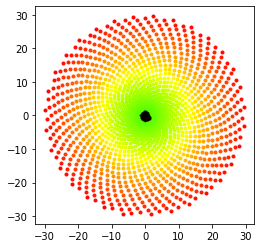

In [16]:
def rgb_conv(i): #converteer nummer naar een kleur
    color = np.array(colorsys.hsv_to_rgb(i/3.59, 1.0, 1.0)) #dit eerste is een kleurenwiel: hue , saturation value
    return tuple(color.astype(float))
    #de factor i/3.59 landt de hue voor waarden i:1 tot 0 in echte waarden 100 tot 0 (dit is percentueel)

def place_stars(R,a,n,M,richting):
    dr = R/n
    stars = []
    color=1
    d = 2
    a0 = 0
    for i in range(n):
        color-=1/(n+1)
        #nu snelheid uit 'centripetale kracht' gelijkstellen aan zwaartekracht:
        v = np.sqrt((G*M)/d) #'keplerian decline'
        if richting=='linksom':
            vy = v*np.cos(a0) #max in hoek = 0°
            vx = -v*np.sin(a0) #max in hoek = 270°
        else:
            vy = -v*np.cos(a0) #max in hoek = 0°
            vx = v*np.sin(a0) #max in hoek = 270°
        stars.append([d*np.cos(a0), d*np.sin(a0), 0, color,vx,vy,0])#[x,y,z,kleur,vx,vy,vz]
        d+=dr
        a0+=a
    return stars

plt.clf()
s = np.array(place_stars(28, 0.2, 1500,M1,'linksom'))
for i in range(len(s)):
    plt.plot(*s[i][:2], '.', color=rgb_conv(s[i][3]))
plt.axis('scaled')
plt.scatter(0,0,color='black',marker='o',s=300)#nucleus
plt.show()

Hierbij werd uitgegaan dat de meeste massa zich in de kern bevindt en we dus de wetten van kepler mogen hanteren voor de snelheden van de sterren te bepalen, echter bleek het nodig om de ene galaxie in wijzerzin te draaiien in tegenstelling tot de andere galaxie. Vervolgens moeten we de hierboven gedefinieerde stercoördinaten nog roteren en transleren om de coordinaten in het oorspronkelijke referentiestelsel te vinden:

In [43]:
def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])
  
def Rz(theta):
    return np.matrix([[ np.cos(theta), -np.sin(theta), 0 ],
                   [ np.sin(theta), np.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

def rotation(stars, i, omega):
    st = np.copy(stars)
    R = Rz(-omega)*Rx(-i) #totale operatiematrix
    for i in range(len(st)): #voor alle sterren
        s = np.array([st[i][:3]]).T #x,y en z rotatieklaar maken
        v = np.array([st[i][4:]]).T #vx,vy en vz rotatieklaar maken (mag wegens rotatie om oorsprong..denk ik)
        st[i][:3]=np.transpose(R*s)
        st[i][4:]=np.transpose(R*v)
    return st

def translation(stars, dr):
    s = np.copy(stars)
    for i in range(3):
        s[:, i]+=dr[i]
    return s

Aantal_sterren = 1000
Max_straal = 8 #hier komt nog 2kpc bij
Hoek_interval = 0.2

S1 = np.array(place_stars(Max_straal, Hoek_interval, Aantal_sterren,M1,'linksom'))
S2 = np.array(place_stars(Max_straal, Hoek_interval, Aantal_sterren,M2,'linksom'))

g1 = rotation(S1,  I1, Omega1) #vorm x,y,z,kleur,vx,vy,vz
g2 = translation(rotation(S2, I2, Omega2), R2_0)
g = np.append(g1, g2, axis = 0)
#s = mlab.points3d(*np.transpose(g[:,:4]), scale_mode = 'none', scale_factor = 0.1)
#mlab.points3d(0,0,0,color=(0,0,0))
R2 = kernposities(0)
#mlab.points3d(R2[0],R2[1],0,color=(0,0,0))
#mlab.axes()
#mlab.show()

Er werd ervan uitgegaan dat dit zoals de melkweg galaxiën zijn met een normale straal van ongeveer 30 kpc. Nu wordt in de volgende code gekeken naar hoe deze galaxiën eruit zien na een tijd T, u hoeft deze niet te runnen aangezien het resultaat erna wordt weergegeven.

In [44]:
def galaxy_evolution(gi, T ,v,t0=0):
    for i in range(len(gi)):#voor elke ster
        r0 = gi[i][:3]
        v0 = gi[i][4:] + np.array(v)
        q = update_ster(v0, r0, T,t0)
        gi[i][:3] = q[-1][:3]
        gi[i][4:] = q[-1][3:]
    return gi
T = 0.46#dichtste nadering bij $$\approx 0.46$$
g1 = galaxy_evolution(g1, T ,V1_0)
g2 = galaxy_evolution(g2, T ,V2_0)
g = np.append(g1[:,:4], g2[:,:4], axis = 0)
R2 = kernposities(T)
s = mlab.points3d(*np.transpose(g[:,:4]),colormap='hot', scale_mode = 'none', scale_factor = 0.3)
mlab.points3d(0,0,0,color=(0,0,0))
mlab.points3d(R2[0],R2[1],0,color=(0,0,0))

#mlab.axes()
mlab.show()

KeyboardInterrupt: 

Na T=1.2, overeenkomend met 977.8*1.2 = 1173.36 miljoen of 1.17 miljard jaar, zien we dit: (open deze foto misschien eens apart om de trailings beter te zien, hij zit in de folder 'afbeeldingen')

![title](afbeeldingen/galaxie_1_cool.png)

![title](afbeeldingen/heic0812c.jpg)

Nu zullen we eens een kijkje nemen naar de galaxie Arp87, hierbij vertrekken we van eenzelfde procedure:

In [ ]:
%%capture
# galaxie1:
M1 = 1.5*10**11
I1= np.pi/2 #deze face-on
Omega1 = np.pi/6
R1_0 = [0,0,0]
V1_0 = [0,0,0]
#galaxie2:
M2 = 5*10**10
I2= 0 #deze edge-on
Omega2 = np.pi/6
R2_0 = [-45,0, 0]
V2_0 = [71,-120, 0]
mu = G*(M1+M2)
BaanEnergie=(V2_0[0]**2 + V2_0[1]**2 + V2_0[2]**2)/2 - mu/((R2_0[0]**2 + R2_0[1]**2 + R2_0[2]**2)**(1/2))
a = -mu/(2*BaanEnergie)
n = np.sqrt(mu/(abs(a)**3))
h = np.linalg.norm(np.cross(R2_0,V2_0))
e = np.sqrt(1 - (h**2)/(mu*a))
e_vec = 1/mu*np.cross(V2_0,np.cross(R2_0,V2_0)) - R2_0/np.linalg.norm(R2_0) #dient om te roteren van x'y' naar xy
E_init = -np.arccos((a-np.linalg.norm(R2_0))/(a*e))
M0 = E_init - e*np.sin(E_init) #dient om de startpositie weer te geven
periode_P = 2*np.pi*a*np.sqrt(a/mu)

def kernposities(tijd):
    #Middelbare Anomalie E
    E0 = M0 + n*tijd
    E = E0
    for k in range(0,10):
        E = E0 + e*np.sin(E) # M + e*sin(E) = E
    R2 = [0,0,0]    
    x = a*(np.cos(E) - e)
    y = a*np.sqrt(1-e**2)*np.sin(E)
    R2[0] = x*e_vec[0]/e - y*e_vec[1]/e
    R2[1] = x*e_vec[1]/e + y*e_vec[0]/e
    return R2

X,Y = [],[]
for tijd in range(0,300):
    r2_ = kernposities(tijd*0.02)
    X.append(r2_[0])
    Y.append(r2_[1])
    print(np.sqrt(r2_[1]**2+r2_[0]),tijd*0.02)
    
fig,ax = plt.subplots()
T = np.arange(0,300,1)
def animate(i):
    ax.clear()
    ax.scatter(0,0,color = 'r')
    ax.scatter(X[i],Y[i])
    ax.set_xlim(-200,200)
    ax.set_ylim(-200,200)
    
anim = FuncAnimation(fig, animate,frames=300, interval=10)

Hier wederom een korte animatie van hoe de kernen rond elkaar bewegen:

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
def norm(r):
    return np.linalg.norm(r)

def vergelijking_stersnelheid(R,r,i):
    return G*(-M1*r[i]/(norm(r)**3)+ M2*(R[i]-r[i])/(norm(np.subtract(R,r))**3) - M2*R[i]/(norm(R)**3))

def ODEs(q, t):
    r = [q[0],q[1],q[2]]
    dv = np.zeros(3)
    for i in range(3):   
        dv[i] = vergelijking_stersnelheid(kernposities(t),r,i)
    return [q[3], q[4], q[5], *dv]
    
def update_ster(v0,r0,T,t0=0,n=10000):
    q0 = [*r0, *v0] #q = [x,y,z,vx,vy,vz]
    t = np.array([*np.linspace(t0, T, n)])
    return odeint(ODEs, q0, t)

def place_stars(R,a,n,M):
    dr = R/n
    stars = []
    color=1
    d = 2
    a0 = 0
    for i in range(n):
        color-=1/(n+1)
        #nu snelheid uit 'centripetale kracht' gelijkstellen aan zwaartekracht:
        v = np.sqrt((G*M)/d) #'keplerian decline'
        vy = v*np.cos(a0) #max in hoek = 0°
        vx = -v*np.sin(a0) #max in hoek = 270°
        stars.append([d*np.cos(a0), d*np.sin(a0), 0, color,vx,vy,0])#[x,y,z,kleur,vx,vy,vz]
        d+=dr
        a0+=a
    return stars

Aantal_sterren = 1500
Max_straal = 20 #hier komt nog 2kpc bij
Hoek_interval = 0.2

S1 = np.array(place_stars(Max_straal, Hoek_interval, Aantal_sterren,M1))
S2 = np.array(place_stars(Max_straal, Hoek_interval, Aantal_sterren,M2))

g1 = rotation(S1,  I1, Omega1) #vorm x,y,z,kleur,vx,vy,vz
g2 = translation(rotation(S2, I2, Omega2), R2_0)

T = 0.22
g1 = galaxy_evolution(g1, T ,V1_0)
g2 = galaxy_evolution(g2, T ,V2_0)
g = np.append(g1[:,:4], g2[:,:4], axis = 0)
R2 = kernposities(T)
s = mlab.points3d(*np.transpose(g[:,:4]), scale_mode = 'none', scale_factor = 0.3)
mlab.points3d(0,0,0,color=(0,0,0))
mlab.points3d(R2[0],R2[1],0,color=(0,0,0))

mlab.show()

We zien na T=0.22, oftewel na 215.116 miljoen jaar, het volgende:

![title](afbeeldingen/galaxie_2_20kpc_1500_0.22.png)

![title](afbeeldingen/Arp87.jpg)